In [ ]:
import pandas as pd
import numpy as np
import heapq
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Load the dataset
df = pd.read_csv("telescope_data.csv", index_col=0)

In [8]:
# Balancing the dataset
df_g = df[df["class"] == "g"]
df_h = df[df["class"] == "h"]

df_g_sampled = df_g.sample(n=len(df_h), random_state=42)
df_balanced = pd.concat([df_g_sampled, df_h])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [9]:
# Splitting dataset into train, validation, test sets
n = len(df_balanced)
train_df = df_balanced[: int(0.7 * n)]
val_df = df_balanced[int(0.7 * n) : int(0.85 * n)]
test_df = df_balanced[int(0.85 * n) :]

# Separate features and labels
X_train = train_df.drop(columns=["class"]).values
y_train = train_df["class"].values
X_val = val_df.drop(columns=["class"]).values
y_val = val_df["class"].values
X_test = test_df.drop(columns=["class"]).values
y_test = test_df["class"].values

In [10]:
# distance calculation
def euclidean_distance(point1, point2):
    return np.sum((point1 - point2) ** 2)


# K Nearest Neighbors algorithm
def KNN(features, labels, k, point):
    heap = []
    for i in range(len(features)):
        distance = euclidean_distance(features[i], point)
        if len(heap) < k:
            heapq.heappush(heap, (-distance, labels[i]))
        elif -distance > heap[0][0]:
            heapq.heappushpop(heap, (-distance, labels[i]))
    neighbors = [label for _, label in heap]
    return max({"g", "h"}, key=neighbors.count)

In [ ]:
k_values = range(1, 21, 2)

# Evaluate on validation set
best_accuracy_sklearn = 0
k_best_sklearn = 0
best_accuracy_custom = 0
k_best_custom = 0
sklearn_accuracies = []
custom_accuracies = []
for k in k_values:
    custom_predictions = [KNN(X_train, y_train, k, point) for point in X_val]
    custom_accuracy = np.mean(np.array(custom_predictions) == y_val)
    if custom_accuracy > best_accuracy_custom:
        best_accuracy_custom = custom_accuracy
        k_best_custom = k
    custom_accuracies.append(custom_accuracy)
    knn_sklearn = KNeighborsClassifier(n_neighbors=k)
    knn_sklearn.fit(X_train, y_train)
    sklearn_accuracy = knn_sklearn.score(X_val, y_val)
    if sklearn_accuracy > best_accuracy_sklearn:
        best_accuracy_sklearn = sklearn_accuracy
        k_best_sklearn = k
    sklearn_accuracies.append(sklearn_accuracy)

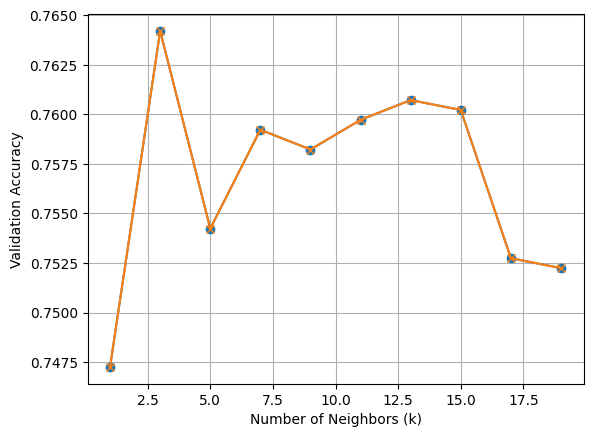

Best k for Custom KNN: 3 with accuracy: 0.7642073778664008
Best k for Scikit-learn KNN: 3 with accuracy: 0.7642073778664008


In [ ]:
# Plotting the accuracies
plt.plot(k_values, custom_accuracies, label="Custom KNN", marker="o")
plt.plot(k_values, sklearn_accuracies, label="Scikit-learn KNN", marker="x")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Validation Accuracy")
plt.grid()
plt.show()
print(f"Best k for Custom KNN: {k_best_custom} with accuracy: {best_accuracy_custom}")
print(
    f"Best k for Scikit-learn KNN: {k_best_sklearn} with accuracy: {best_accuracy_sklearn}"
)

Classification Report for Custom KNN:
              precision    recall  f1-score   support

           g       0.73      0.82      0.78       999
           h       0.80      0.70      0.75      1008

    accuracy                           0.76      2007
   macro avg       0.77      0.76      0.76      2007
weighted avg       0.77      0.76      0.76      2007



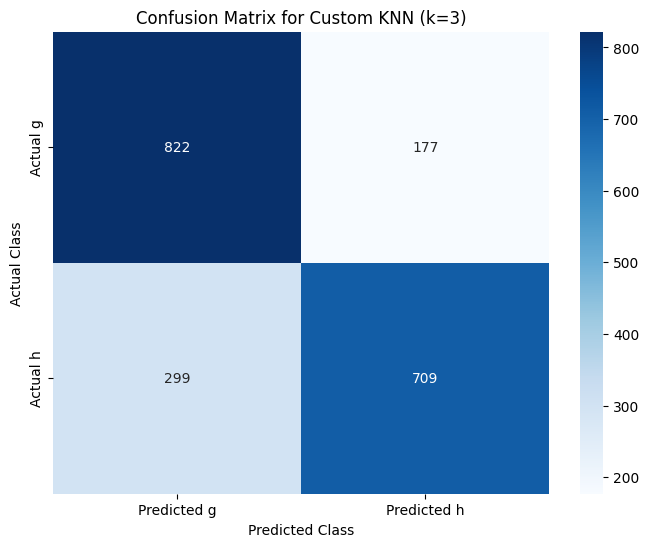

Classification Report for Scikit-learn KNN:
              precision    recall  f1-score   support

           g       0.73      0.82      0.78       999
           h       0.80      0.70      0.75      1008

    accuracy                           0.76      2007
   macro avg       0.77      0.76      0.76      2007
weighted avg       0.77      0.76      0.76      2007



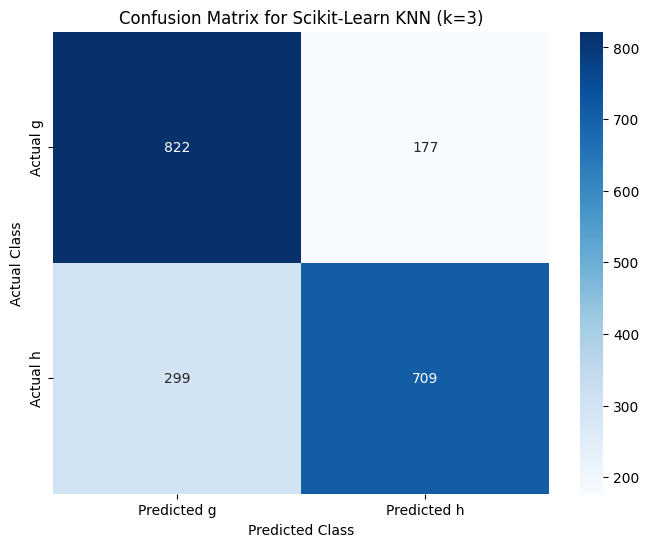

In [ ]:
# Evaluate Custom KNN on test set
custom_predictions = [KNN(X_train, y_train, k_best_custom, point) for point in X_test]
custom_accuracy = accuracy_score(y_test, custom_predictions)

print("Classification Report for Custom KNN:")
print(classification_report(y_test, custom_predictions, target_names=["g", "h"]))

cm = confusion_matrix(y_test, custom_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Predicted g", "Predicted h"],
    yticklabels=["Actual g", "Actual h"],
)
plt.title(f"Confusion Matrix for Custom KNN (k={k_best_custom})")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# Evaluate Scikit-learn KNN on test set
knn_sklearn = KNeighborsClassifier(n_neighbors=k_best_sklearn)
knn_sklearn.fit(X_train, y_train)
skilearn_predictions = knn_sklearn.predict(X_test)
skilearn_accuracy = accuracy_score(y_test, skilearn_predictions)

print("Classification Report for Scikit-learn KNN:")
print(classification_report(y_test, skilearn_predictions, target_names=["g", "h"]))

cm2 = confusion_matrix(y_test, skilearn_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm2,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Predicted g", "Predicted h"],
    yticklabels=["Actual g", "Actual h"],
)
plt.title(f"Confusion Matrix for Scikit-Learn KNN (k={k_best_sklearn})")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()